# Subject Continuity

In this notebook, we calculate the BERT embedding distance and WordNet path distance on a final selection of 5504 poems from GPoeT-2 as well as the same amount of randomly sampled OEDILF poems for comparison.

After the metrics on the poems are computed, they are stored for future use. In addition, we subsample 500 poems from each of the two sets and plot the results.

## BERT

In [ ]:
!pip install transformers
import torch
import numpy as np
import random
from transformers import BertTokenizerFast, BertModel
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import random
import scipy
from nltk.corpus import wordnet as wn

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

In [3]:
def get_token_embeddings(tokenizer, model, poem):
    """Retrieve the BERT embedding of each token in a poem

    :param tokenizer: BERT Fast tokenizer
    :param model: BERT pre-trained model
    :param poem: poem as a single string
    :return: (mapping of word index to token, embeddings for each token)
    """
    # Tokenize the poem
    marked_poem = "[CLS] " + poem + " [SEP]"
    bert_tokenized_poem = tokenizer.tokenize(marked_poem)

    # Get the word to token ID mapping
    encoded_poem = tokenizer(poem)
    word_ids = encoded_poem.word_ids()
    word_to_token = list(zip(word_ids, bert_tokenized_poem))[1:-1]

    num_words = word_to_token[-1][0] + 1
    word_token_mapping = [[] for _ in range(num_words)]

    for token_index, (word_id, token) in enumerate(word_to_token):
        word_token_mapping[word_id].append(token_index)

    # Get all hidden states
    indexed_tokens = tokenizer.convert_tokens_to_ids(bert_tokenized_poem)
    segment_ids = [1] * len(bert_tokenized_poem)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    model.eval()
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states = torch.stack(outputs[2], dim=0).squeeze(dim=1).permute(1,0,2)

    # Concat last four layers as final embedding
    embeddings = []
    for token in hidden_states[1:-1]:
        last_four_layers = torch.cat([token[-i] for i in range(1, 5)], dim=0)
        embeddings.append(last_four_layers)
    
    return word_token_mapping, embeddings


def get_nouns_in_poem(poem):
    """Extract all nouns and their word index from a poem

    :param poem: One poem as a single string
    :return: list of tuples: (word index, noun as string)
    """
    is_noun = lambda pos: pos[:2] == 'NN'
    nltk_tokenized_poem = nltk.word_tokenize(poem)
    nouns = [(i, word) for i, (word, pos) in enumerate(nltk.pos_tag(nltk_tokenized_poem)) if is_noun(pos)]
    return nouns


def filter_and_combine_embeddings(filter_word_ids, word_token_mapping, embeddings, verbose=False):
    """Filter for only the noun embeddings and combine multiple tokens that correspond to the same word

    :param filter_word_ids: word IDs from the poem that should be kept
    :param word_token_mapping: mapping from word IDs to token IDs
    :param embeddings: actual BERT embeddings to use
    :param verbose: verbose mode with additional debug output
    :return: list of filtered embeddings (one per noun)
    """
    filtered_embeddings = []
    for word_id in filter_word_ids:
        if word_id >= len(word_token_mapping):
            return None
        tokens = word_token_mapping[word_id]
        num_tokens = len(tokens)
        if verbose:
            print(f"Found {num_tokens} for word {word_id}")
        avg_embedding = embeddings[tokens[0]]
        for token_id in tokens[1:]:
            avg_embedding += embeddings[token_id]
        avg_embedding /= num_tokens
        filtered_embeddings.append(avg_embedding.cpu().detach().numpy())
    return filtered_embeddings


def calculate_centroid(embeddings):
    """Calculate the centroid of a given number of points in the embedding space

    :param embeddings: list of points in the embedding space
    :return: list of filtered embeddings (one per noun)
    """
    num_points = len(embeddings)
    if num_points == 0:
        return None
    sum = np.zeros(len(embeddings[0]))
    for i in range(num_points):
        sum += embeddings[i]
    centroid = sum / num_points
    return centroid


def get_distances_from_centroid(centroid, embeddings):
    """Calculate the distance from the centroid for a given number of points

    :param embeddings: centroid of the points provided
    :param embeddings: list of points in the embedding space
    :return: list of filtered embeddings (one per noun)
    """
    num_points = len(embeddings)
    distances = []
    for embedding in embeddings:
        diff = centroid - embedding
        distance = np.linalg.norm(diff)
        distances.append(distance)
    return np.array(distances)

### GPoeT-2

In [4]:
""" Load the GPoeT-2 poems """
filtered_gpoet2_poems_file = open('04_21_free_form_spell_checked_12832_ld_10702_class_5504.json')
filtered_gpoet2_poems = json.load(filtered_gpoet2_poems_file)
print("number of poems: ", len(filtered_gpoet2_poems), '\n')
print(filtered_gpoet2_poems[list(filtered_gpoet2_poems.keys())[0]])

number of poems:  5504 

of course I must get my hair swept clean;
all my bangs are still clean. I'm a teen.
so lift me right back
when the world takes the quack:
the exit is the exit I'll preen.


In [ ]:
""" Calculate the BERT embedding noun to centroid distances """
gpoet2_metrics = {}

for id, gpt2_poem in tqdm(filtered_gpoet2_poems.items()):
    word_token_mapping, embeddings = get_token_embeddings(tokenizer, model, gpt2_poem)
    noun_word_ids = [x[0] for x in get_nouns_in_poem(gpt2_poem)]
    filtered_embeddings = filter_and_combine_embeddings(noun_word_ids, word_token_mapping, embeddings)
    
    if filtered_embeddings is None:
        gpoet2_metrics[id] = None
        continue

    centroid = calculate_centroid(filtered_embeddings)

    if centroid is None:
        gpoet2_metrics[id] = None
        continue

    distances = get_distances_from_centroid(centroid, filtered_embeddings)

    gpoet2_metrics[id] = {"mean": distances.mean(), "std": distances.std()}

In [ ]:
""" Store metrics as a JSON file for later use (avoid recomputation every time) """
with open('centroid_metrics_04_21_free_form_spell_checked_12832_ld_10702_class_5504.json', 'w') as f:
    json.dump(gpoet2_metrics, f)

### OEDILF

In [5]:
""" Load the OEDILF poems """
with open('limericks.json', 'r') as f:
    json_data = json.load(f)
oedilf_poems = json_data['limericks']
print("number of OEDILF poems: ", len(oedilf_poems), '\n')

number of OEDILF poems:  72432 



In [ ]:
""" Sample an equal number of OEDILF poems and Calculate the BERT embedding noun to centroid distances """

oedilf_metrics = {}
oedilf_poem_indices = random.sample(oedilf_poems.keys(), len(filtered_gpoet2_poems))

for oedilf_poem_index in tqdm(oedilf_poem_indices):
    oedilf_poem = '\n'.join(oedilf_poems[oedilf_poem_index]['lines'])

    word_token_mapping, embeddings = get_token_embeddings(tokenizer, model, oedilf_poem)
    noun_word_ids = [x[0] for x in get_nouns_in_poem(oedilf_poem)]
    filtered_embeddings = filter_and_combine_embeddings(noun_word_ids, word_token_mapping, embeddings)

    if filtered_embeddings is None:
        oedilf_metrics[oedilf_poem_index] = None
        continue

    centroid = calculate_centroid(filtered_embeddings)

    if centroid is None:
        oedilf_metrics[oedilf_poem_index] = None
        continue

    distances = get_distances_from_centroid(centroid, filtered_embeddings)

    oedilf_metrics[oedilf_poem_index] = {"mean": distances.mean(), "std": distances.std()}

In [ ]:
""" Store metrics as a JSON file for later use (avoid recomputation every time) """
with open('centroid_metrics_oedilf_5504.json', 'w') as f:
    json.dump(oedilf_metrics, f)

### Run experiment

In [6]:
with open('/content/centroid_metrics_04_21_free_form_spell_checked_12832_ld_10702_class_5504.json', 'r') as f:
    gpoet2_centroid_metrics = json.load(f)
gpoet2_centroid_metrics_list = list(gpoet2_centroid_metrics.items())
gpoet2_centroid_metrics_list = [(id, metrics) for (id, metrics) in gpoet2_centroid_metrics_list if metrics is not None]

In [7]:
with open('/content/centroid_metrics_oedilf_5504.json', 'r') as f:
    oedilf_centroid_metrics = json.load(f)
oedilf_centroid_metrics_list = list(oedilf_centroid_metrics.items())

In [8]:
""" Sample 500 poems from both GPoeT-2 and OEDILF and retrieve corresponding statistics """
num_points = 500

gpoet2_sample = random.sample(gpoet2_centroid_metrics_list, num_points)
oedilf_sample = random.sample(oedilf_centroid_metrics_list, num_points)

gpt2_means, gpt2_stds = [], []
for (id, metrics) in gpoet2_sample:
    gpt2_means.append(metrics['mean'])
    gpt2_stds.append(metrics['std'])
assert len(gpt2_means) == num_points
assert len(gpt2_stds) == num_points

oedilf_means, oedilf_stds = [], []
for (id, metrics) in oedilf_sample:
    oedilf_means.append(metrics['mean'])
    oedilf_stds.append(metrics['std'])
assert len(oedilf_means) == num_points
assert len(oedilf_stds) == num_points

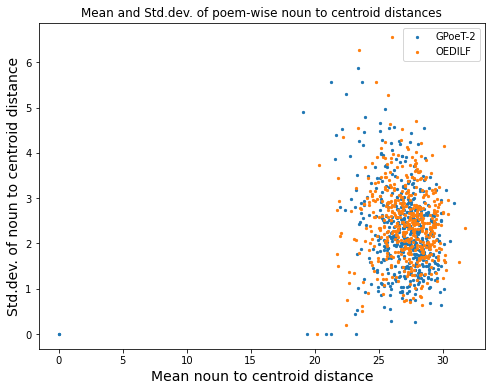

Ttest_indResult(statistic=1.5545474786841444, pvalue=0.12039804920726825)

In [9]:
""" Plot results and run T-test """

plt.figure(figsize=(8,6))
plt.scatter(gpt2_means, gpt2_stds, label='GPoeT-2', s=5)
plt.scatter(oedilf_means, oedilf_stds, label='OEDILF', s=5)
plt.title('Mean and Std.dev. of poem-wise noun to centroid distances')
plt.xlabel("Mean noun to centroid distance", size=14)
plt.ylabel("Std.dev. of noun to centroid distance", size=14)
plt.legend()
plt.show()

scipy.stats.ttest_ind(oedilf_means, gpt2_means, axis=0, equal_var=False)

# WordNet

In [10]:
def get_two_noun_distance(n1, n2, verbose=False, similarity_metric='path'):
    """Get the WordNet distance of two given words with the specified similarity metric

    :param n1: First noun to use
    :param n2: Second noun to use
    :param verbose: verbose mode with additional debug output
    :param similarity_metric: WordNet similarity metric to use
    :return: maximum similarity between any two meanings of the two provided nouns
    """
    assert(similarity_metric in ['path', 'lch', 'wup']), f"Invalid similarity metric {similarity_metric}"

    if similarity_metric == 'path':
        metric = wn.path_similarity
    elif similarity_metric == 'lch':
        metric = wn.lch_similarity
    elif similarity_metric == 'wup':
        metric = wn.wup_similarity

    syns1, syns2 = wn.synsets(n1, pos=wn.NOUN), wn.synsets(n2, pos=wn.NOUN)
    max_similarity = -1
    for syn1 in syns1:
        for syn2 in syns2:
            similarity = metric(syn1, syn2)
            max_similarity = max(max_similarity, similarity)
    max_similarity = round(max_similarity,4)
    if verbose:
        print(f"Distance between {n1} and {n2} is {max_similarity}")

    if max_similarity == -1:
        return None

    return max_similarity


def get_avg_pairwise_noun_distance(nouns, verbose=False, similarity_metric='path'):
    """Compute the average pairwise noun similarity of a sequence of nouns

    :param nouns: List of nouns to use
    :param verbose: verbose mode with additional debug output
    :param similarity_metric: WordNet similarity metric to use
    :return: average pairwise WordNet noun similarity
    """
    total_dist = 0
    pairs = 0

    for i in range(len(nouns)):
        for j in range(i+1, len(nouns)):
            if nouns[i] == nouns[j]:
                continue
            dist = get_two_noun_distance(nouns[i], nouns[j], verbose=verbose, similarity_metric=similarity_metric)
            if dist:
                total_dist += dist
                pairs += 1

    if pairs == 0:
        return None

    return total_dist / pairs

### GPoeT-2

In [ ]:
gpoet2_avg_path_dist = {}

for id, gpoet2_poem in tqdm(filtered_gpoet2_poems.items()):
    nouns = get_nouns_in_poem(gpoet2_poem)
    nouns = [x[1] for x in nouns]

    gpoet2_avg_path_dist[id] = get_avg_pairwise_noun_distance(nouns, similarity_metric='path')

In [ ]:
with open('wordnet_metrics_04_21_free_form_spell_checked_12832_ld_10702_class_5504.json', 'w') as f:
    json.dump(gpoet2_avg_path_dist, f)

### OEDILF

In [ ]:
oedilf_avg_path_dist = {}

for oedilf_poem_index in tqdm(oedilf_poem_indices):
    oedilf_poem = '\n'.join(oedilf_poems[oedilf_poem_index]['lines'])

    nouns = get_nouns_in_poem(oedilf_poem)
    nouns = [x[1] for x in nouns]

    oedilf_avg_path_dist[oedilf_poem_index] = get_avg_pairwise_noun_distance(nouns, similarity_metric='path')

In [ ]:
with open('wordnet_metrics_oedilf_5504.json', 'w') as f:
    json.dump(oedilf_avg_path_dist, f)

### Run experiment

In [11]:
with open('/content/wordnet_metrics_04_21_free_form_spell_checked_12832_ld_10702_class_5504.json', 'r') as f:
    gpoet2_wordnet_metrics = json.load(f)
gpoet2_wordnet_metrics_list = list(gpoet2_wordnet_metrics.items())
gpoet2_wordnet_metrics_list = [(id, distance) for (id, distance) in gpoet2_wordnet_metrics_list if distance is not None]

In [12]:
with open('/content/wordnet_metrics_oedilf_5504.json', 'r') as f:
    oedilf_wordnet_metrics = json.load(f)
oedilf_wordnet_metrics_list = list(oedilf_wordnet_metrics.items())
oedilf_wordnet_metrics_list = [(id, distance) for (id, distance) in oedilf_wordnet_metrics_list if distance is not None]

In [13]:
gpoet2_sample = random.sample(gpoet2_wordnet_metrics_list, num_points)
oedilf_sample = random.sample(oedilf_wordnet_metrics_list, num_points)

gpoet2_path_distances = []
for (id, distance) in gpoet2_sample:
    gpoet2_path_distances.append(distance)
assert len(gpoet2_path_distances) == num_points

oedilf_path_distances = []
for (id, distance) in oedilf_sample:
    oedilf_path_distances.append(distance)
assert len(oedilf_path_distances) == num_points

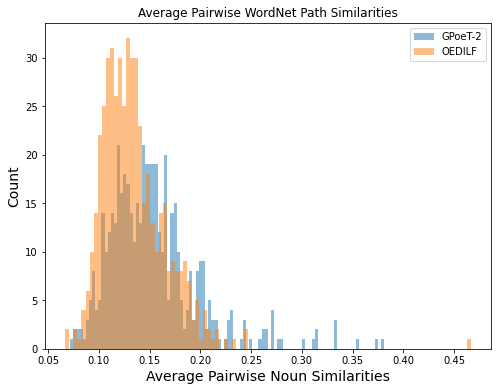

Ttest_indResult(statistic=-7.516424749652683, pvalue=1.3478029186176363e-13)

In [14]:
plt.figure(figsize=(8,6))
plt.hist(gpoet2_path_distances, bins=100, alpha=0.5, label="GPoeT-2")
plt.hist(oedilf_path_distances, bins=100, alpha=0.5, label="OEDILF")
plt.xlabel("Average Pairwise Noun Similarities", size=14)
plt.ylabel("Count", size=14)
plt.title("Average Pairwise WordNet Path Similarities")
plt.legend(loc='upper right')
plt.show()

scipy.stats.ttest_ind(oedilf_path_distances, gpoet2_path_distances, axis=0, equal_var=False)